In [1]:
#June 6

import ares
import numpy as np
import matplotlib.pyplot as pl


In [2]:
pop_halo = ares.populations.HaloPopulation()
data = ares.analysis.GalaxyPopulation() #for lit values

Specific Star Formation Rates - dependant on galaxy mass  
Whitaker2014

In [3]:
#[a, b, c] - from Table 1
polyPara = [[-27.4, -26.03, -24.04, -19.99], [5.02, 4.62, 4.17, 3.44], [-0.22, -0.19, -0.16, -0.13]]
#4.1. Polynomial
def polyFit(z, mass):
    if 0.5 <= z < 1.0:
        i = 0
    elif 1.0 <= z < 1.5:
        i = 1
    elif 1.5 <= z < 2.0:
        i = 2
    elif 2.0 <= z < 2.5:
        i = 3
    else:
        print("Out of redshift range")
        return 0        
    
    return polyPara[0][i] + polyPara[1][i]*np.log10(mass) + polyPara[2][i]*(np.log10(mass))**2 #Equ 2

#From Table 3
b = [1.11, 1.31, 1.49, 1.62]
def pl_HL(z, mass):
    if 0.5 <= z < 1.0:
        i = 0
    elif 1.0 <= z < 1.5:
        i = 1
    elif 1.5 <= z < 2.0:
        i = 2
    elif 2.0 <= z < 2.5:
        i = 3
    else:
        print("Out of redshift range")
        return 0        
    
    alpha_L = 0.95 + 0.02*z
    alpha_H = 0.03 + 0.31*z #Equ 4
        
    a = []
    for m in mass:
        if m <= 10**10.2:
            a.append(alpha_L)
        else:
            a.append(alpha_H)
    
    return a*(np.log10(mass)-10.2) + b[i] #Equ 3

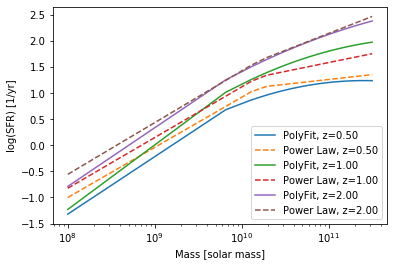

In [4]:
Sm = np.linspace(10**8.0, 10**11.5)

for z in [0.5, 1, 2]:
    SFR_P = polyFit(z, Sm)
    # print(SFR)
    SFR_pl = pl_HL(z, Sm)

    pl.semilogx(Sm, SFR_P, label="PolyFit, z=%.2f" %z)
    pl.semilogx(Sm, SFR_pl, label="Power Law, z=%.2f" %z, ls="--")

pl.legend()
pl.ylabel('log(SFR) [1/yr]')
pl.xlabel('Mass [solar mass]')
# pl.title('')

# pl.ylim(1e-25, 10)
pl.show()

In [5]:
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM, z_at_value
import scipy.integrate as integrate

cosmo = FlatLambdaCDM(H0=70*u.km/u.s/u.Mpc, Om0=0.3)

# z_at_value(cosmo.age, 0.5 * u.Gyr)

### Main Sequence: stellar mass vs. SFR relationship  
Speagle2014 - using a compilation of 25 studies from literature  
5.1 The Evolution of the Galaxy “Main Sequence”

In [6]:
"""
The interpublication scatter around this fit is σi = (0.08, 0.09, 0.11) dex, for the minimum, median, and maximum 
values within the fitted mass range logM∗ = 9.7 – 11.1, respectively. This encompasses a majority of the age of 
the Universe (z ∼ 0.25 – 2.75), and provides good fits to the observed SFRs all the way out z ∼ 5

If redshift=True (default) age is given in redshift, else it should be in Gyr
"""
def phi(age, mass, redshift=True):
    if redshift:
        t = cosmo.age(age).value
    else:
        t = age

    # t: age of universe in Gyr

    if t < cosmo.age(6).value: # if t > z=6
        print("Warning, age out of well fitting zone of this model.")
#     print(mass)
    return (0.84-0.026*t)*np.log10(mass) - (6.51-0.11*t) #Equ 28


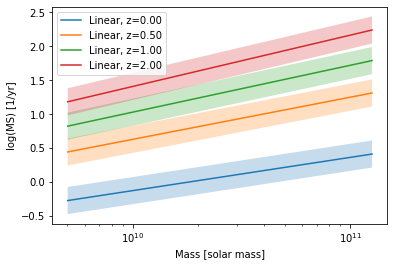

In [7]:
Sm = np.linspace(10**9.7, 10**11.1)

for z in [0, 0.5, 1, 2]:
    SFR = phi(z, Sm)
    error = np.ones(len(SFR)) * 0.2 #dex #the stated "true" scatter

    pl.semilogx(Sm, SFR, label="Linear, z=%.2f" %z)
    pl.fill_between(Sm, SFR-error, SFR+error, alpha=0.25)

pl.legend()
pl.ylabel('log(MS) [1/yr]')
pl.xlabel('Mass [solar mass]')
# pl.title('')

pl.show()

z = np.linspace(.1, 4, 100)

### specific star formation rate
$SSFR = \frac{SFR}{SM}$

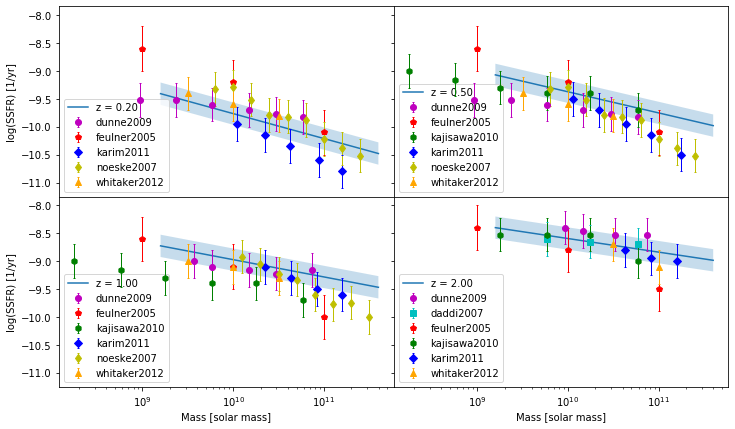

In [14]:
Sm = np.linspace(10**9.2, 10**11.6)

fig, axs = pl.subplots(2, 2, figsize=(12, 7), sharex=True, sharey=True)
axs = axs.flatten()
pl.subplots_adjust(hspace=0, wspace=0)

for i, z in enumerate([0.2, 0.5, 1, 2]):
    
    data.PlotSSFR(z=z, round_z=0.3, ax=axs[i])
    
    SFR = phi(z, Sm) - np.log10(Sm)

    error = np.ones(len(SFR)) * 0.2
    axs[i].set_xscale('log')

    axs[i].plot(Sm, SFR, label="z = %.2f" %z, )
    axs[i].fill_between(Sm, SFR-error, SFR+error, alpha=0.25)
    if i%2==0:
        axs[i].set(xlabel='Mass [solar mass]', ylabel='log(SSFR) [1/yr]')

    axs[i].legend()
axs[i].set(xlabel='Mass [solar mass]')

pl.show()

### Cosmic SFR density (SFRD)

$$ SFRD(z) = \int SFR(z,M_s) \cdot SMF(z, M_s) dM_s \approx \sum_{M_s}[SFR(z,M_s) \cdot SMF(z, M_s) \cdot dM_s] $$ 
$dM_s$: stellar mass bin size  
SMF = number density  


In [9]:
import GalaxyHOD

In [10]:
#for each mass, get sfr (sSFR) * number density of that mass
# then 'integrate' over all the masses

pop = GalaxyHOD.GalaxyHOD()
bins = np.logspace(9.5, 11.5)

Zs = np.linspace(0, 8, 50)
SFRD = []

for z in Zs:
    numberD = pop.StellarMassFunction(z, bins, False) #need to add an option to suppress the message

    SFR = 10**phi(z, bins)/bins # cause we don't want the value loged i think?
    error = 0.2 * SFR * np.log(10)

    dbin = [] #does this get the right bins?
    for i in range(0, len(bins) - 1):
        dbin.append(bins[i+1]-bins[i])

    SFRD_val = np.sum( numberD[:-1] * SFR[:-1] * dbin )
    SFRD_err = np.sqrt(np.sum( numberD[:-1] * dbin * error[:-1])**2)
    
    SFRD.append([SFRD_val, SFRD_err])

SFRD = np.transpose(SFRD) # [sfrd, err]

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.
Warning, age out of well fitting zone of this model.


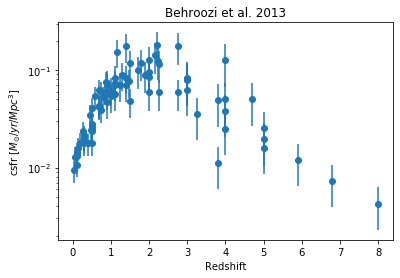

In [70]:
# importing some data from behroozi-2013: csfrs_new.dat
# Columns: redshift, Log10(CSFR) (Msun/yr/Mpc^3), Err+ (dex), Err- (dex)

text = "../behroozi-2013-data-compilation/csfrs_new.dat"
csfrs = np.transpose(np.loadtxt(text))

logphi_ML = csfrs[1]
err = csfrs[2]

logphi_lo_tmp = logphi_ML - err   # log10 phi
logphi_hi_tmp = logphi_ML + err   # log10 phi

phi_lo = 10**logphi_lo_tmp
phi_hi = 10**logphi_hi_tmp

err1 = 10**logphi_ML - phi_lo
err2 = phi_hi - 10**logphi_ML

pl.yscale('log')
pl.errorbar(csfrs[0], 10**csfrs[1], yerr=err1, ls="", marker="o", label="Behroozi csfrs")
# pl.semilogy(csfrs[0], 10**csfrs[1], ls="", marker="o")
pl.ylabel('csfr $[M_{\odot}/yr/Mpc^3]$')
pl.xlabel('Redshift')
pl.title('Behroozi et al. 2013')
pl.show()

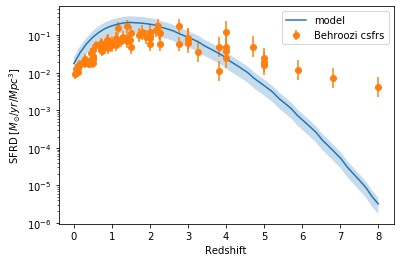

In [69]:
pl.semilogy(Zs, SFRD[0], label="model")
pl.fill_between(Zs, SFRD[0]-SFRD[1], SFRD[0]+SFRD[1], alpha=0.25) #do these do the logy axis properly?

pl.errorbar(csfrs[0], 10**csfrs[1], yerr=[err1, err2], ls="", marker="o", label="Behroozi csfrs" )

pl.ylabel('SFRD $[M_{\odot}/yr/Mpc^3]$')
pl.xlabel('Redshift')
pl.legend()

pl.show()